# Classification of three arrythmia types 

AI in Healthcare project

## Load dependencies and define arrythmia types

Define the arrythmia types I want to have a closer look at.


In [87]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy import stats, signal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import shap

In [88]:
class ArrhythmiaTypes(Enum):
    SB = "SB"
    AFIB = "AFIB"
    SR = "SR"

## Load and prepare the data

In the following step the diagnostic data and the ecg data is combined into a data frame.

In [89]:
diagnostics_file = 'Diagnostics.xlsx'
diagnostics_data = pd.read_excel(diagnostics_file)

# Filter the diagnostics data based on Arrhythmia types in the enum
allowed_rhythms = [arrhythmia.value for arrhythmia in ArrhythmiaTypes]
filtered_diagnostics_data = diagnostics_data[diagnostics_data['Rhythm'].isin(allowed_rhythms)]

combined_data_list = []

ecg_files = os.listdir('ECGData')

# My Laptop is not good enough to handle more files, the code takes forever to run -> you can remove this line if your hardware is better
files_limit = 200

for i, file_name in enumerate(ecg_files):
    if i >= files_limit:
        break

    ecg_file_path = os.path.join('ECGData', file_name)

    ecg_data = pd.read_csv(ecg_file_path)
    #ecg_data = ecg_data.iloc[1:].reset_index(drop=True)

    # Find the corresponding row in the filtered diagnostics data
    diagnostics_row = filtered_diagnostics_data[filtered_diagnostics_data['FileName'] == file_name.replace('.csv', '')]

    if not diagnostics_row.empty:
        combined_dict = diagnostics_row.iloc[0].to_dict()

        # Add ECG data to the dictionary
        for col in ecg_data.columns:
            combined_dict[f'ECG_{col}'] = ecg_data[col].tolist()

        combined_data_list.append(combined_dict)

combined_df = pd.DataFrame(combined_data_list)

# Replace empty lists with NaN
combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

print(combined_df.iloc[0])
print("Number of patient entries after filtering: ", len(combined_df.index))


FileName                                  MUSE_20180209_170349_37000
Rhythm                                                            SR
Beat                                                            NONE
PatientAge                                                        66
Gender                                                        FEMALE
VentricularRate                                                   61
AtrialRate                                                        61
QRSDuration                                                       72
QTInterval                                                       388
QTCorrected                                                      390
RAxis                                                             40
TAxis                                                             39
QRSCount                                                          11
QOnset                                                           220
QOffset                           

/var/folders/pb/22cxtyzd653c2q7dxd_fy0_r0000gp/T/ipykernel_2217/2606527861.py:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)


## Data exploration

Before I start the exploration I want to have a look at the percentage of each arrythmia type in the unfiltered dataset to choose the most common arrythmia types.

In [90]:
def analyze_arrhythmia_distribution(diagnostics_file_path):
    df = pd.read_excel(diagnostics_file_path)
    
    # Count the occurrences of each arrhythmia type
    arrhythmia_counts = df['Rhythm'].value_counts()
    
    # Calculate percentages
    total_count = len(df)
    arrhythmia_percentages = (arrhythmia_counts / total_count) * 100
    
    distribution_df = pd.DataFrame({
        'Count': arrhythmia_counts,
        'Percentage': arrhythmia_percentages
    })
    
    print("Arrhythmia Distribution:")
    print(distribution_df)

analyze_arrhythmia_distribution('Diagnostics.xlsx')


Arrhythmia Distribution:
        Count  Percentage
Rhythm                   
SB       3889   36.530152
SR       1826   17.151982
AFIB     1780   16.719895
ST       1568   14.728537
SVT       587    5.513808
AF        445    4.179974
SA        399    3.747887
AT        121    1.136577
AVNRT      16    0.150291
AVRT        8    0.075146
SAAWR       7    0.065752


First I want to have a general overview over the data in the filtered dataset: the gender, age and arrythmia type distribution.

In [91]:
# Visualize Gender Distribution
def visualize_gender():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Gender', data=filtered_diagnostics_data)
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

# Calculate exact numbers
def calc_gender():
    gender_counts = filtered_diagnostics_data['Gender'].value_counts()
    total_counts = combined_df.shape[0]

    print("Number of data sets by gender:")
    print(gender_counts)

In [92]:
# Visualize Age Distribution
def visualize_age():
    plt.figure(figsize=(4, 2))
    sns.histplot(filtered_diagnostics_data['PatientAge'], kde=True, bins=10)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

# Calculate exact numbers
def calc_age_boxplot():
    age = filtered_diagnostics_data['PatientAge']
    min_age = age.min()
    max_age = age.max()
    mean_age = age.mean()
    median_age = age.median()
    std_dev_age = age.std()

    # Create box plot
    plt.figure(figsize=(4, 2))
    ax = sns.boxplot(y=age, color='lightblue')

    plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.2f}')
    plt.axhline(median_age, color='green', linestyle='-', label=f'Median: {median_age:.2f}')
    plt.title('Box Plot of Patient Age with Mean and Median')
    plt.ylabel('Age')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("Age Statistics:")
    print(f"Minimum Age: {min_age}")
    print(f"Maximum Age: {max_age}")
    print(f"Mean Age: {mean_age:.2f}")
    print(f"Median Age: {median_age}")
    print(f"Standard Deviation of Age: {std_dev_age:.2f}")

In [93]:
# Visualize Arrythmia Distribution
def visualize_arrythmia():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Rhythm', data=filtered_diagnostics_data)
    plt.title('Arrythmia Types Distribution')
    plt.xlabel('Arrythmia Type')
    plt.ylabel('Count')
    plt.show()

In [94]:
# Visualize gender and age
def visualize_gender_age():
    plt.figure(figsize=(4, 2))
    sns.boxplot(x='Gender', y='PatientAge', data=combined_df)
    plt.title('Age Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Age')
    plt.show()

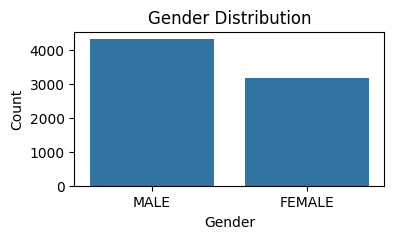

Number of data sets by gender:
Gender
MALE      4324
FEMALE    3171
Name: count, dtype: int64


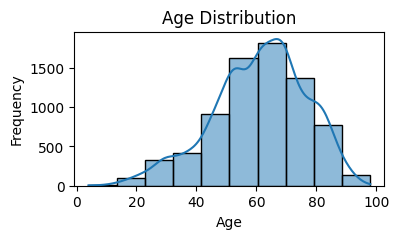

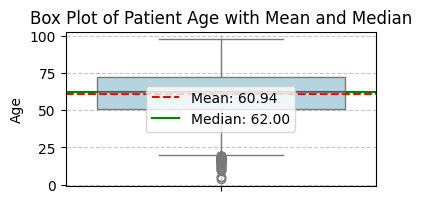

Age Statistics:
Minimum Age: 4
Maximum Age: 98
Mean Age: 60.94
Median Age: 62.0
Standard Deviation of Age: 15.69


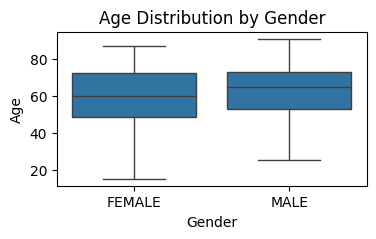

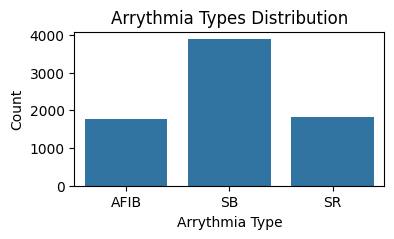

In [95]:
visualize_gender()
calc_gender()
visualize_age()
calc_age_boxplot()
visualize_gender_age()
visualize_arrythmia()

Next I want to compare the ECG leads for the different arrythmia types. The following visualization shows the various arrythmia types and the distribution of thei values and potential outliers:

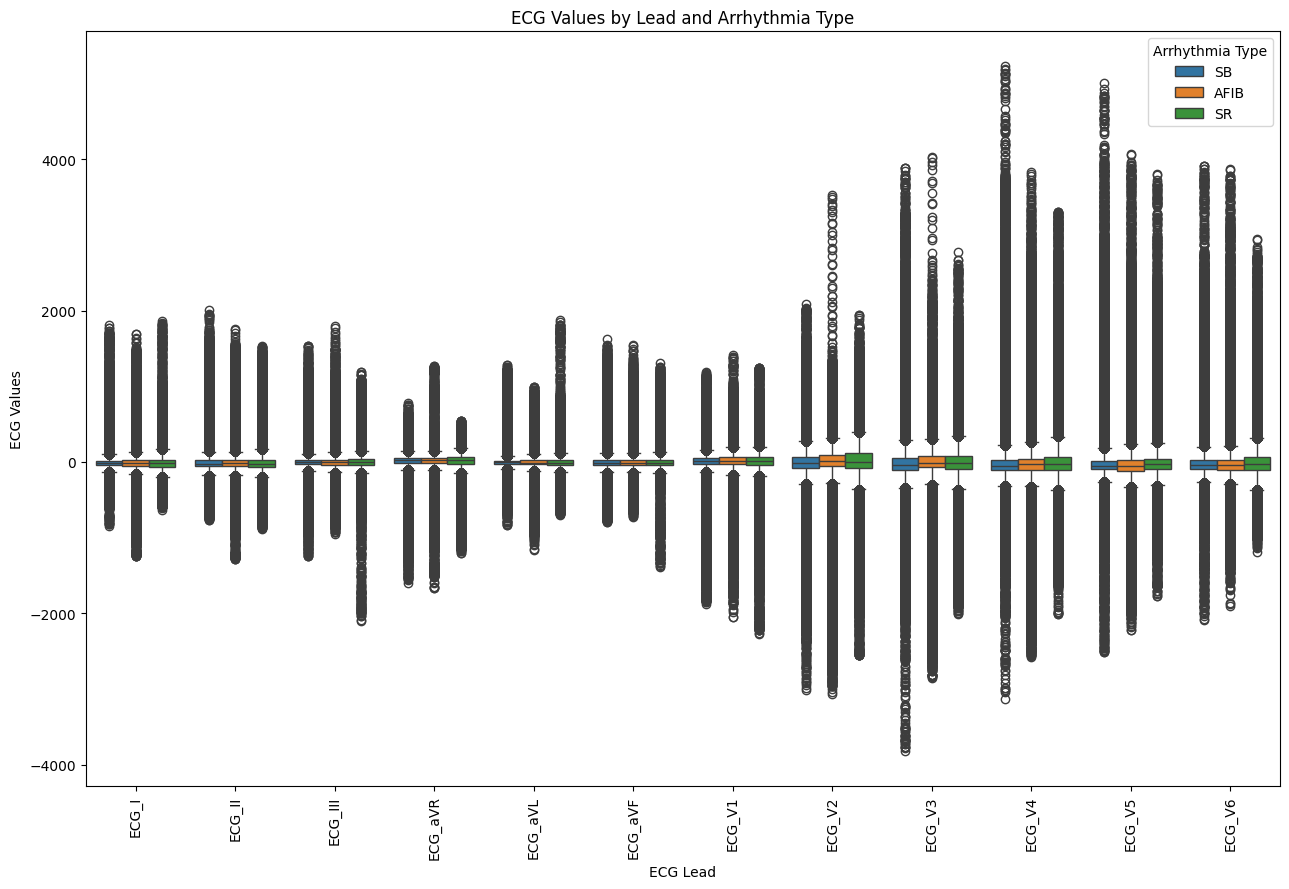

In [96]:
def plot_combined_ecg_boxplots(combined_df):
    # List of ECG columns
    ecg_leads = [col for col in combined_df.columns if col.startswith('ECG_')]
    
    ecg_data_combined = []
    
    for lead in ecg_leads:
        # Flatten the ECG data lists for each arrhythmia type
        for arrhythmia_type in ArrhythmiaTypes:
            data = combined_df[combined_df['Rhythm'] == arrhythmia_type.value][lead]
            if isinstance(data.iloc[0], list):  # Check if data is a list
                data = [item for sublist in data.dropna() for item in sublist]
            else:
                data = data.dropna()
            
            ecg_data_combined.append(pd.DataFrame({
                'ECG_Lead': lead,
                'Arrhythmia': arrhythmia_type.value,
                'ECG_Value': data
            }))
    
    # Combine all data into one DataFrame
    combined_df_ecg = pd.concat(ecg_data_combined)
    
    plt.figure(figsize=(13, 9))
    sns.boxplot(x='ECG_Lead', y='ECG_Value', hue='Arrhythmia', data=combined_df_ecg)
    
    plt.title('ECG Values by Lead and Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('ECG Values')
    plt.legend(title='Arrhythmia Type')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()

# This takes too long for more patient data which is why I left it out of the analysis
plot_combined_ecg_boxplots(combined_df)

Now I want to have a closer look at each lead/channel:

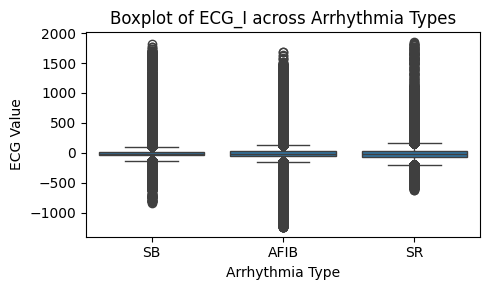

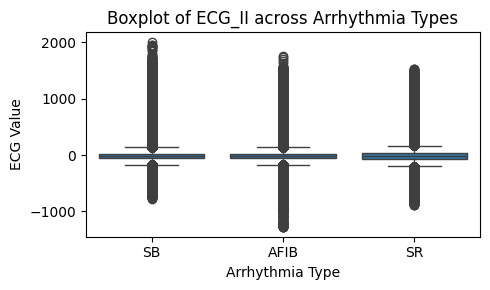

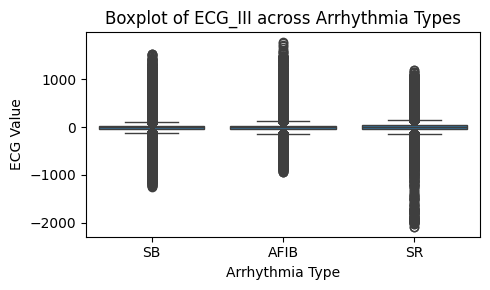

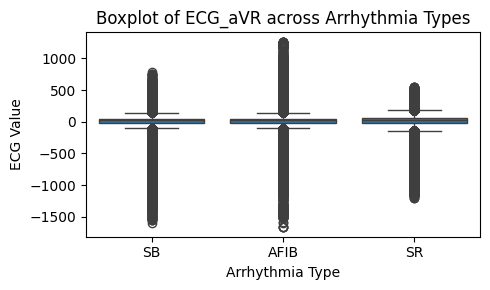

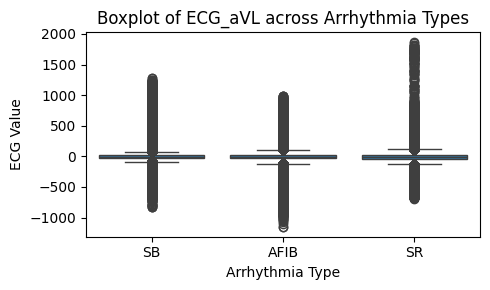

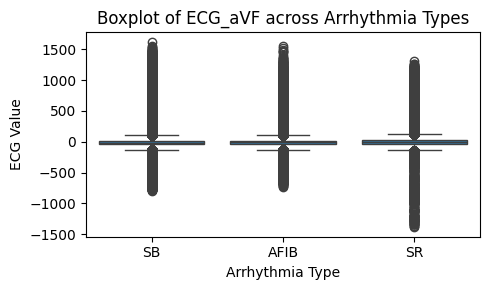

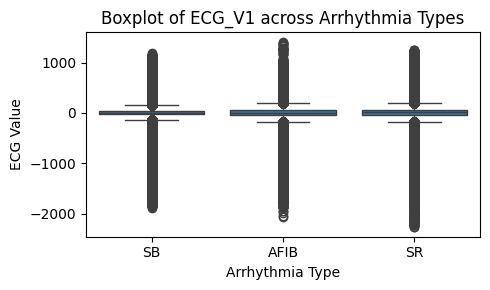

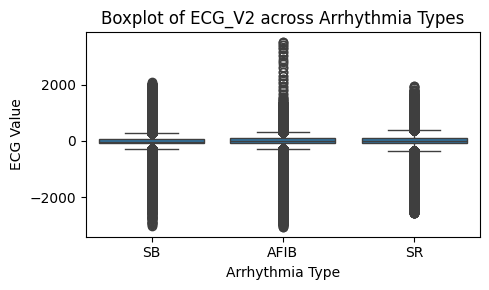

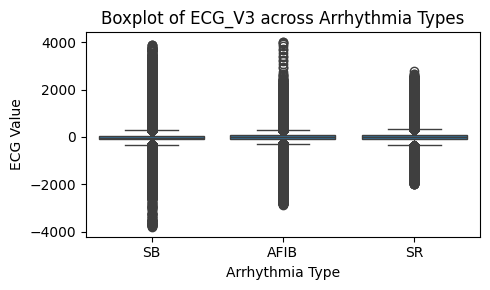

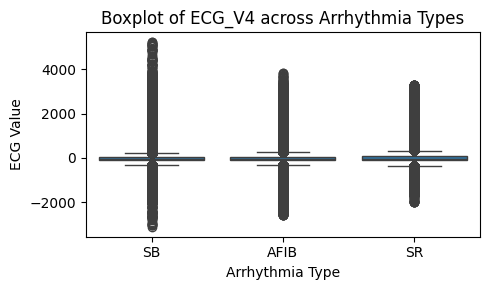

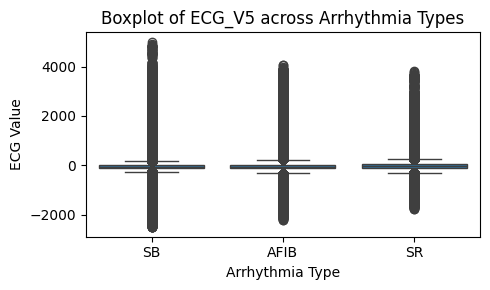

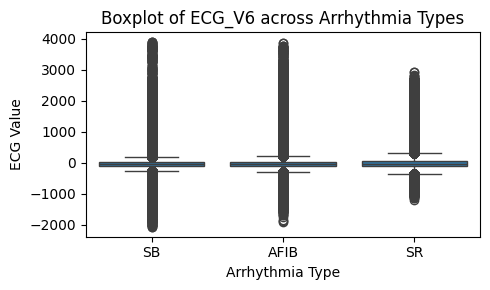

In [97]:
def compare_arrhythmias(combined_df):
    melted_data = []
    
    for arrhythmia_type in ArrhythmiaTypes:
        filtered_df = combined_df[combined_df['Rhythm'] == arrhythmia_type.value]
        
        for col in filtered_df.columns:
            if col.startswith('ECG_'):
                # For each ECG lead, concatenate the data and store it along with the arrhythmia type
                ecg_data = np.concatenate(filtered_df[col].dropna().values)
                for value in ecg_data:
                    melted_data.append({'ECG_Lead': col, 'ECG_Value': value, 'Arrhythmia': arrhythmia_type.value})
    
    # Convert to a DataFrame for visualization
    melted_df = pd.DataFrame(melted_data)
    
    ecg_leads = melted_df['ECG_Lead'].unique()
    
    # Plot the boxplots for each ECG lead
    for lead in ecg_leads:
        plt.figure(figsize=(5, 3))
        
        # Filter data for the current lead
        lead_data = melted_df[melted_df['ECG_Lead'] == lead]
        
        sns.boxplot(x='Arrhythmia', y='ECG_Value', data=lead_data)
        
        plt.title(f'Boxplot of {lead} across Arrhythmia Types')
        plt.ylabel('ECG Value')
        plt.xlabel('Arrhythmia Type')
        
        plt.tight_layout()
        plt.show()

compare_arrhythmias(combined_df)

Next I want to look at the variance of the ECG leads across the different arrythmia types:

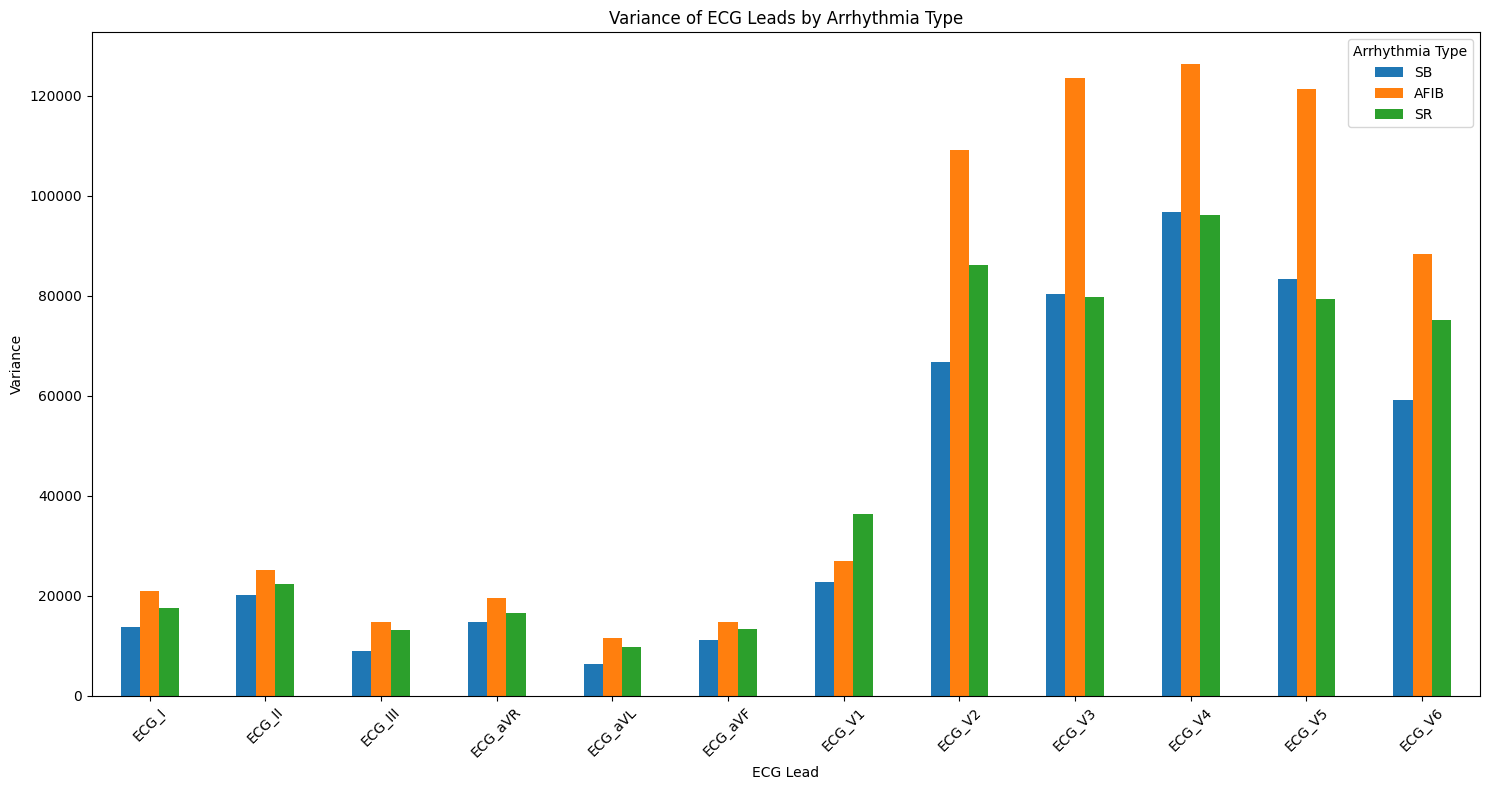

In [98]:
def calculate_variance(df, arrhythmia_type):
    filtered_df = df[df['Rhythm'] == arrhythmia_type.value]
    variances = {}
    for col in filtered_df.columns:
        if col.startswith('ECG_'):
            ecg_data = np.concatenate(filtered_df[col].dropna().values)
            variances[col] = np.var(ecg_data)
    return pd.Series(variances, name=arrhythmia_type.value)

def visualize_variances(combined_df):
    # Calculate variance for each arrhythmia type
    variance_dfs = []
    for arrhythmia_type in ArrhythmiaTypes:
        variance_series = calculate_variance(combined_df, arrhythmia_type)
        variance_dfs.append(variance_series)

    # Combine all variances into a single DataFrame
    variances_df = pd.concat(variance_dfs, axis=1)
    variances_df.columns = [arrhythmia_type.value for arrhythmia_type in ArrhythmiaTypes]
    
    variances_df.plot(kind='bar', figsize=(15, 8))
    plt.title('Variance of ECG Leads by Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('Variance')
    plt.xticks(rotation=45)
    plt.legend(title="Arrhythmia Type")
    plt.tight_layout()
    plt.show()

visualize_variances(combined_df)


## Data analysis

In this section I will prepare the data for the ML model.

### Data cleaning

First I will do some basic steps to clean the data (handling missing data values, removing outliers). Afterwards the ECG readings are normalized using Z-Score-normalization. Then butterworth filtering is applied to remove basline wandering and low-pass filtering is apllied to remove high-frequency noise.

In [138]:
def handle_missing_values(data):
    # Interpolate missing values
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        if np.isnan(data).any():
            nans, x = np.isnan(data), lambda z: z.nonzero()[0]
            data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    elif pd.isna(data):
        return np.nan
    return data

def remove_outliers(data):
    # Remove outliers using IQR method
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(data, lower_bound, upper_bound)
    else:
        return data

def z_score_normalize(data):
    # Calculate mean and standard deviation
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        mean = np.mean(data)
        std = np.std(data)
        
        # Avoid division by zero
        if std == 0:
            return np.zeros_like(data)
        
        # Perform z-score normalization
        normalized_data = (data - mean) / std
        return normalized_data
    else:
        return data

def remove_baseline_wander(ecg_signal, sampling_rate):
    # Design a highpass filter
    nyquist_freq = 0.5 * sampling_rate
    cutoff = 0.5 / nyquist_freq
    b, a = signal.butter(1, cutoff, btype='high', analog=False)
    
    # Apply the filter
    return signal.filtfilt(b, a, ecg_signal)

def reduce_noise(ecg_signal, sampling_rate):
    # Design a lowpass filter
    nyquist_freq = 0.5 * sampling_rate
    cutoff = 50 / nyquist_freq
    b, a = signal.butter(6, cutoff, btype='low', analog=False)
    
    # Apply the filter
    return signal.filtfilt(b, a, ecg_signal)

def clean_ecg_signal(ecg_signal):
    # Sampling rate as defined in the paper
    sampling_rate = 500
    
    # Convert to numpy array
    ecg_signal = np.array(ecg_signal)
    
    # Handle missing values
    ecg_signal = handle_missing_values(ecg_signal)

    # Remove baseline wander
    ecg_signal = remove_baseline_wander(ecg_signal, sampling_rate)
    
    # Reduce high-frequency noise
    ecg_signal = reduce_noise(ecg_signal, sampling_rate)
    
    # Remove outliers
    ecg_signal = remove_outliers(ecg_signal)

    # Perform z-score normalization
    ecg_signal = z_score_normalize(ecg_signal)
    
    return ecg_signal

def clean_numeric_value(value):
    # Handle missing values
    value = handle_missing_values(value)
    
    # Remove outliers
    value = remove_outliers(value)
    
    return value

def normalize_numeric_column(column):
    return z_score_normalize(column)


In [145]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def clean_data(combined_df):
    # Create a copy of the dataframe to avoid modifying the original
    cleaned_df = combined_df.copy()

    # Identify ECG columns
    ecg_columns = [col for col in cleaned_df.columns if col.startswith('ECG_')]
    
    if not ecg_columns:
        raise ValueError("No ECG columns found in the DataFrame.")
    
    # Identify numeric columns (excluding ECG columns)
    numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ecg_columns]
    
    # Clean ECG data
    for col in ecg_columns:
        cleaned_df[col] = cleaned_df[col].apply(clean_ecg_signal)
    
    scaler = StandardScaler()
    cleaned_df[numeric_columns] = scaler.fit_transform(cleaned_df[numeric_columns])
    
    print("\nAfter normalization:")
    print(cleaned_df[numeric_columns].iloc[0])
    
    # Print sample of final cleaned data
    print("\nSample of final cleaned data:")
    print(cleaned_df.iloc[0])
    
    return cleaned_df

# Apply the cleaning function
cleaned_df = clean_data(combined_df)


After normalization:
PatientAge         0.280759
VentricularRate   -0.340810
AtrialRate        -0.302577
QRSDuration       -1.440170
QTInterval        -0.446788
QTCorrected       -1.076963
RAxis             -0.064489
TAxis              0.067121
QRSCount          -0.023163
QOnset             0.044399
QOffset           -1.269129
TOffset           -0.426498
Name: 0, dtype: float64

Sample of final cleaned data:
FileName                                  MUSE_20180209_170349_37000
Rhythm                                                            SR
Beat                                                            NONE
PatientAge                                                  0.280759
Gender                                                        FEMALE
VentricularRate                                             -0.34081
AtrialRate                                                 -0.302577
QRSDuration                                                 -1.44017
QTInterval                         

### Feature Extraction


214 Features are exracted for the analysis:

In [146]:
def extract_time_domain_features(ecg_series):
    return pd.Series({
        'mean': np.mean(ecg_series),
        'std': np.std(ecg_series),
        'max': np.max(ecg_series),
        'min': np.min(ecg_series),
        'range': np.ptp(ecg_series),
        'median': np.median(ecg_series),
        'skewness': stats.skew(ecg_series),
        'kurtosis': stats.kurtosis(ecg_series),
        'rms': np.sqrt(np.mean(np.square(ecg_series))),
        'peak_to_peak': np.max(ecg_series) - np.min(ecg_series)
    })

def extract_frequency_domain_features(ecg_series):
    # Compute Power Spectral Density
    f, psd = signal.welch(ecg_series, fs=250, nperseg=256)  # Assuming 250 Hz sampling rate
    
    # Define frequency bands
    vlf = (0.003, 0.04)  # Very low frequency
    lf = (0.04, 0.15)   # Low frequency
    hf = (0.15, 0.4)    # High frequency
    
    # Calculate power in each band
    vlf_power = np.trapezoid(psd[(f >= vlf[0]) & (f <= vlf[1])])
    lf_power = np.trapezoid(psd[(f >= lf[0]) & (f <= lf[1])])
    hf_power = np.trapezoid(psd[(f >= hf[0]) & (f <= hf[1])])
    total_power = vlf_power + lf_power + hf_power
    
    return pd.Series({
        'vlf_power': vlf_power,
        'lf_power': lf_power,
        'hf_power': hf_power,
        'lf_hf_ratio': lf_power / hf_power if hf_power != 0 else 0,
        'vlf_power_normalized': vlf_power / total_power if total_power != 0 else 0,
        'lf_power_normalized': lf_power / total_power if total_power != 0 else 0,
        'hf_power_normalized': hf_power / total_power if total_power != 0 else 0
    })

def extract_features(df):
    ecg_columns = ['ECG_I', 'ECG_II', 'ECG_III', 'ECG_aVR', 'ECG_aVL', 'ECG_aVF', 'ECG_V1', 'ECG_V2', 'ECG_V3', 'ECG_V4', 'ECG_V5', 'ECG_V6']
    
    features = pd.DataFrame()
    
    for col in ecg_columns:
        time_features = df[col].apply(extract_time_domain_features)
        freq_features = df[col].apply(extract_frequency_domain_features)
        
        time_features.columns = [f'{col}_{feat}' for feat in time_features.columns]
        freq_features.columns = [f'{col}_{feat}' for feat in freq_features.columns]
        
        features = pd.concat([features, time_features, freq_features], axis=1)
    
    # Add other relevant columns
    additional_columns = ['PatientAge', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount']
    features = pd.concat([features, df[additional_columns]], axis=1)
    
    # Convert Gender to numeric
    features['Gender'] = (df['Gender'] == 'MALE').astype(int)
    
    return features

features = extract_features(cleaned_df)
print("Feature extraction complete.")

Feature extraction complete.


### Machine Learning

First of all I will use a simple model to adress the research question: Logistic regression. I will also analyse the model performance. Afterwards I want to have a closer look at the model and its decision so I will apply SHAP and feature importance.

In [147]:
# Create target variable (1 for arrhythmia, 0 for healthy)
y = (cleaned_df['Rhythm'] != 'SR').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

Analysis of the Logistic Regression models performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.83      0.90      0.86        21

    accuracy                           0.79        28
   macro avg       0.71      0.67      0.68        28
weighted avg       0.77      0.79      0.77        28

ROC AUC Score: 0.7891


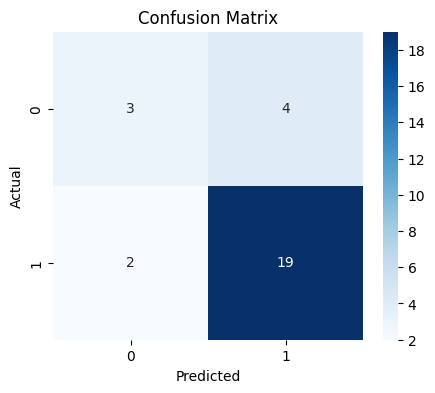

In [148]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print ROC AUC score
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

SHAP analysis and feature importance analysis for the Logistic Regression model:

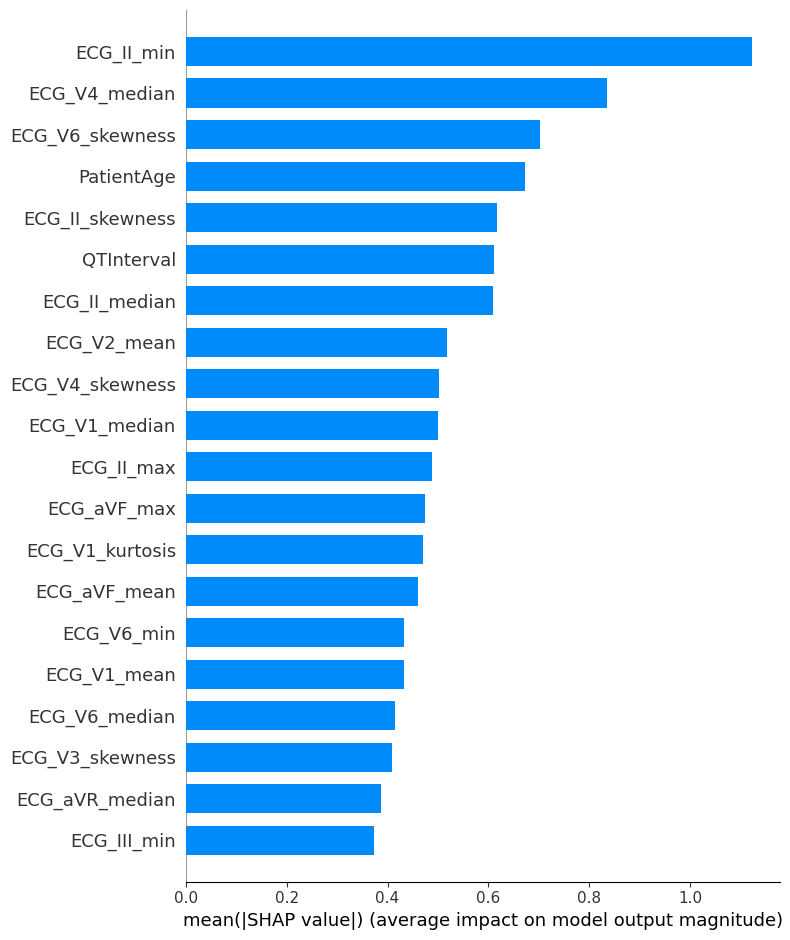

<Figure size 640x480 with 0 Axes>

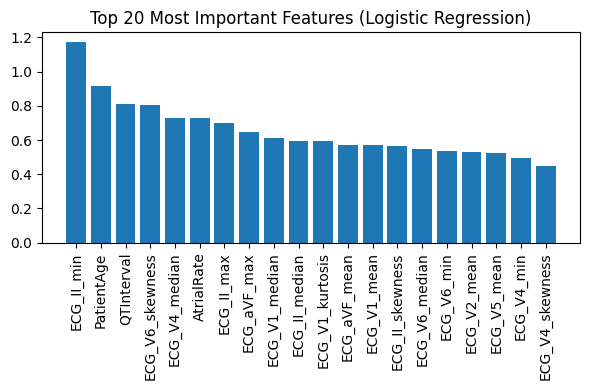

In [149]:
# SHAP Analysis
explainer = shap.LinearExplainer(log_reg, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# Feature importance based on absolute values of coefficients
feature_importance = pd.DataFrame({
    'feature': features.columns,
    'importance': np.abs(log_reg.coef_[0])
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(6, 4))
plt.bar(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Important Features (Logistic Regression)')
plt.tight_layout()
plt.show()

Next I will use a more complex model to adress the reserach question: Random Forest. I will also analyse this models performance. Afterwards the SHAP model is applied to better understand the decision-making process of the model:

In [150]:
# Create target variable (1 for arrhythmia, 0 for normal)
y = (cleaned_df['Rhythm'] != 'SR').astype(int)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

Performance analysis of the Random Forest model:

In [151]:
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.29      0.44         7
           1       0.81      1.00      0.89        21

    accuracy                           0.82        28
   macro avg       0.90      0.64      0.67        28
weighted avg       0.86      0.82      0.78        28



Appling feature importance to the Random Forest model:

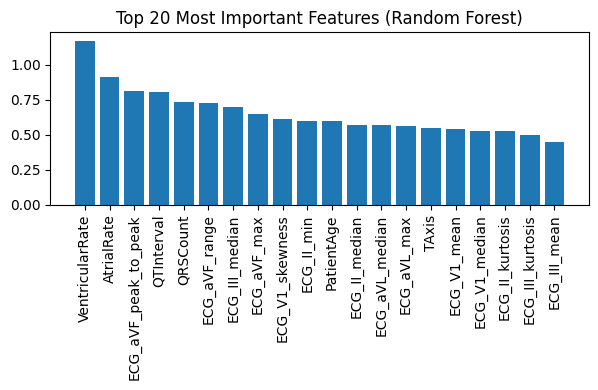

                 feature  importance
0        VentricularRate    0.043698
1             AtrialRate    0.041408
2   ECG_aVF_peak_to_peak    0.032771
3             QTInterval    0.029363
4               QRSCount    0.024760
5          ECG_aVF_range    0.022701
6         ECG_III_median    0.020506
7            ECG_aVF_max    0.020337
8        ECG_V1_skewness    0.019433
9             ECG_II_min    0.016925
10            PatientAge    0.016861
11         ECG_II_median    0.015901
12        ECG_aVL_median    0.015806
13           ECG_aVL_max    0.015021
14                 TAxis    0.014690
15           ECG_V1_mean    0.014636
16         ECG_V1_median    0.014249
17       ECG_II_kurtosis    0.014108
18      ECG_III_kurtosis    0.013832
19          ECG_III_mean    0.013742


In [152]:
# Get feature importances using the built in feature of the RandomForestClassifier
importances = rf_model.feature_importances_
feature_names = features.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

sorted_importances = importances[indices]
sorted_feature_names = feature_names[indices]

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)

# Plot top 20 most important features
plt.figure(figsize=(6, 4))
plt.bar(feature_importance_df['feature'][:20], feature_importance['importance'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# Display the top 20 features
print(feature_importance_df.head(20))

SHAP analysis of the Random Forest model:

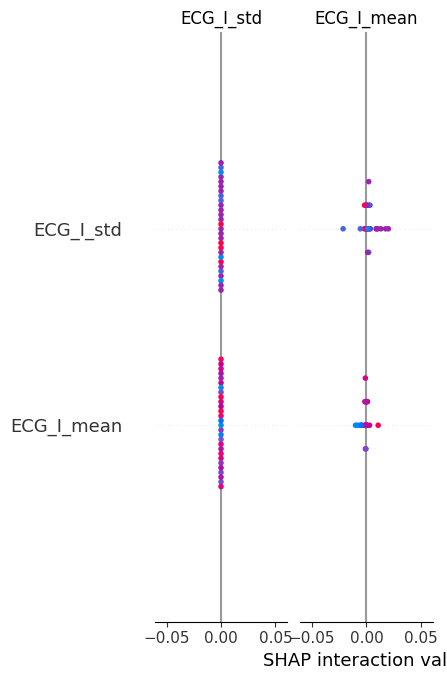

<Figure size 1200x800 with 0 Axes>

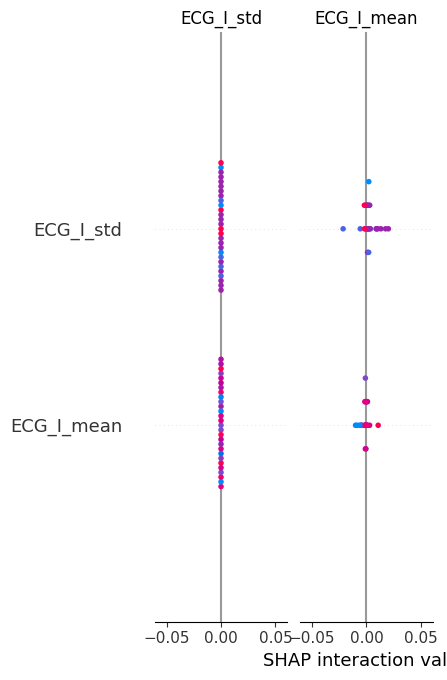

<Figure size 640x480 with 0 Axes>

In [154]:
# SHAP Analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, plot_type="bar")
